# Training a Multitask GP model for Computer Model Emulation

Based on these examples: 
http://inverseprobability.com/talks/notes/deep-gaussian-processes.html
https://github.com/SheffieldML/PyDeepGP/blob/master/examples/tutorial.ipynb

### Import necessary libraries 

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import GPy
import deepgp

In [2]:
from calculations_load import *
from configurations import *

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'main_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/main', 'validation_events_dir': 'model_calculations/production_500pts_Pb_Pb_2760/Events/validation', 'main_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat', 'validation_obs_file': 'model_calculations/production_500pts_Pb_Pb_2760/Obs/validation.dat', 'n_design': 500, 'n_validation': 100, 'design_remove_idx': [289, 483, 32

In [3]:
#prepare the directories for model design and outputs
#run this cell only once, or else it will hang!
#! sh prepare.sh

### Loading Computer Model inputs and outputs

In [4]:
system_str = 'Pb-Pb-2760'
design_file = 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat'
design = pd.read_csv(design_file)
design = design.drop("idx", axis=1)

#delete bad design points
drop_indices = list(delete_design_pts_set)
design = design.drop(drop_indices)

#choose features (inputs)
#feature_cols = ['norm', 'trento_p'] #specific choices
feature_cols = design.keys().values #all of them 
n_features = len(feature_cols)

X = design[feature_cols]

#perform a transformation of the design, swapping the original parameters
#for inputs more naturally/simply related to the outputs
do_transform_design = True
if do_transform_design:
    X = transform_design(X.values)

n_design = SystemsInfo["Pb-Pb-2760"]["n_design"]
npt = n_design - len(delete_design_pts_set)

Y = np.array([])
for pt in range(npt):
    for obs in active_obs_list['Pb-Pb-2760']:
        Y = np.append( Y, trimmed_model_data[system_str][pt, idf][obs]['mean'][:], axis=0)
        
Y = Y.reshape(X.shape[0], -1)

In [5]:
print( "X.shape : "+ str(X.shape) )
print( "Y.shape : "+ str(Y.shape) )

X.shape : (485, 29)
Y.shape : (485, 110)


## Splitting the inputs and outputs into a training and testing set

Then, scaling all of the inputs and outputs to (0, 1)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

feature_range = (-1, 1)
#X_scaler = MinMaxScaler(feature_range = feature_range ).fit(X_train)
#Y_scaler = MinMaxScaler(feature_range = feature_range ).fit(Y_train)
X_scaler = StandardScaler().fit(X_train)
Y_scaler = StandardScaler().fit(Y_train)

X_train_sc = X_scaler.transform(X_train)
X_test_sc = X_scaler.transform(X_test)

Y_train_sc = Y_scaler.transform(Y_train)
Y_test_sc = Y_scaler.transform(Y_test)

### The cell below constructs the DeepGP model

In [7]:
# Number of latent dimensions (single hidden layer, since the top layer is observed)
n_latent = 20

# Define what kernels to use per layer
kern1 = GPy.kern.RBF(n_latent, ARD=True) + GPy.kern.Bias(n_latent)
kern2 = GPy.kern.RBF(n_latent, ARD=False) + GPy.kern.Bias(X_train_sc.shape[1])

# Number of inducing points to use
num_inducing = 50

model = deepgp.DeepGP([Y_train_sc.shape[1], n_latent, X_train_sc.shape[1]],
                  Y_train_sc, X_tr=X_train_sc, kernels=[kern1, kern2], 
                  num_inducing=num_inducing, back_constraint=False)

In [8]:
# Make sure initial noise variance gives a reasonable signal to noise ratio.
# Fix to that value for a few iterations to avoid early local minima
for i in range(len(model.layers)):
    output_var = model.layers[i].Y.var() if i==0 else model.layers[i].Y.mean.var()
    model.layers[i].Gaussian_noise.variance = output_var*0.01
    model.layers[i].Gaussian_noise.variance.fix()

In [9]:
display(model)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(50, 20)",,
obslayer.sum.rbf.variance,1.0,+ve,
obslayer.sum.rbf.lengthscale,"(20,)",+ve,
obslayer.sum.bias.variance,1.0,+ve,
obslayer.Gaussian_noise.variance,0.01,+ve fixed,
obslayer.Kuu_var,"(50,)",+ve,
obslayer.latent space.mean,"(388, 20)",,
obslayer.latent space.variance,"(388, 20)",+ve,
layer_1.inducing inputs,"(50, 29)",,
layer_1.sum.rbf.variance,1.0,+ve,


In [10]:
model.optimize(max_iters=800, messages=True)

In [11]:
# Unfix noise variance now that we have initialized the model
for i in range(len(model.layers)):
    model.layers[i].Gaussian_noise.variance.unfix()

In [12]:
model.optimize(max_iters=1500, messages=True)

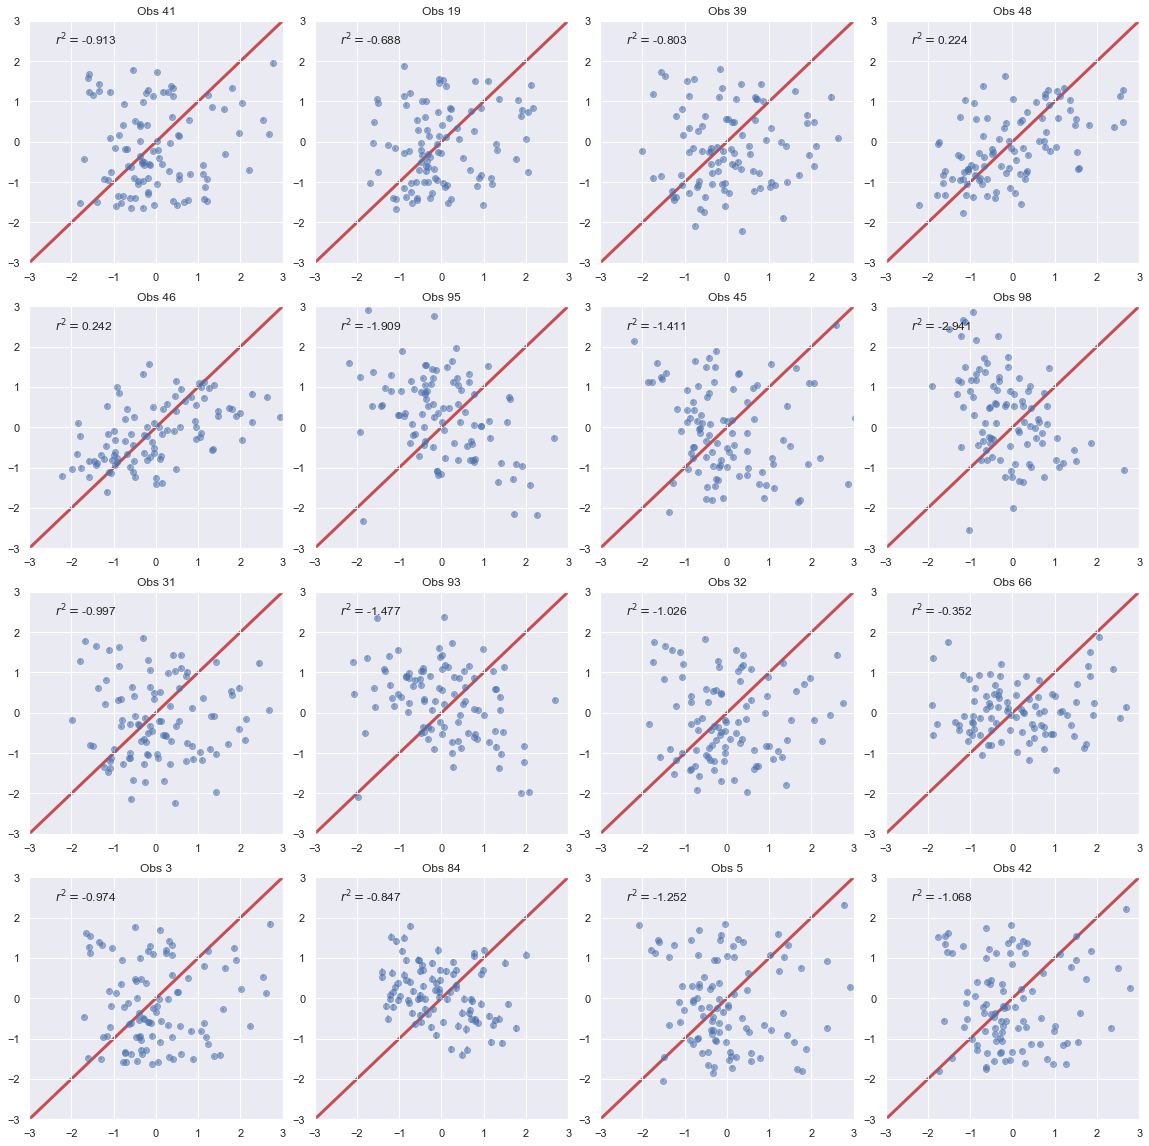

In [14]:
pred_mean = model.predict_withSamples(X_test_sc, nSamples=500)[0]
pred_std = model.predict_withSamples(X_test_sc, nSamples=500)[1]

truth = np.linspace(-3, 3, 100)

sqrt_nplot = 4
n_plot = sqrt_nplot * sqrt_nplot
obs_indices = np.random.choice(110, n_plot, replace=False)

fig, axes = plt.subplots(sqrt_nplot, sqrt_nplot, figsize=(4*sqrt_nplot, 4*sqrt_nplot))
for i, obs_ind in enumerate(obs_indices):
    ax = axes.flatten()[i]
    ax.set_title("Obs " + str(obs_ind))
    ax.plot(truth, truth, c='r', lw=3, zorder=-1)
    ax.errorbar(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind], yerr=pred_std[:, obs_ind],
                alpha=0.5, zorder=1, fmt='o')
    
    
    r2 = r2_score(Y_test_sc[:, obs_ind], pred_mean[:, obs_ind])
    ax.annotate(r'$r^2 = $' + str(round(r2, 3) ), xy=(.1, .9), xycoords="axes fraction", fontsize=12)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
plt.tight_layout(True)
plt.show()

In [ ]:
sigma_res_arr = []
sigma_pred_arr = []

for iobs in range(Y.shape[1]):
    res = pred_mean[:, iobs] - Y_test_sc[:, iobs]
    res = res.numpy()
    sigma_res = np.std(res)
    sigma_pred = np.mean(pred_std[:, iobs].numpy())
    sigma_res_arr.append(sigma_res)
    sigma_pred_arr.append(sigma_pred)


plt.plot(np.arange(0, Y.shape[1]), sigma_res_arr, lw=2, label='width of residual dist.')
plt.plot(np.arange(0, Y.shape[1]), sigma_pred_arr, lw=2, color='r', label='pred. std', ls='--')
plt.legend()
plt.show()

In [ ]:
r2 = r2_score(Y_test_sc,pred_mean)
print("r2 = " + str(round(r2, 3)))

In [ ]:
for param_name, param in model.named_parameters():
    print(param_name)
    print(param.item() )